In [570]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.gridspec as gs
from typing import List

mpl.rcParams['figure.dpi']= 200
mpl.rcParams['axes.titlesize'] = 'large'
mpl.rcParams['axes.labelsize'] = 'large'

In [571]:
plt.style.use('fivethirtyeight')

In [572]:
def get_best_by(df: pd.DataFrame, column: str, col_val: str = 'test error cost'):
    return df[df.groupby([column])[col_val].transform(min) == df[col_val]]

def get_mean_by(df: pd.DataFrame, column: str, col_val: str = 'test error cost'):
    return df.groupby([column], sort=True)[col_val].mean()

In [573]:
def plot_for_column(df: pd.DataFrame, columns: List[str], logy: bool=False):
    fig = plt.figure(constrained_layout=True, figsize=(20, 5 * (1 + len(columns) // 2)))
    fig.tight_layout(rect=[0, 0.5, 1, 1.5])
    fig.suptitle(f'Dependence of error cost on {", ".join(columns)}', fontsize=30)
    spec = gs.GridSpec(ncols=2, nrows=1 + len(columns) // 2, figure=fig)
    for i, column in enumerate(columns):
        ax = fig.add_subplot(spec[i // 2, i % 2])
        ax.set_title(f'Dependence on {column}')
        results = get_best_by(df, column).sort_values(by=column)
        results.plot.line(x=column, y='test error cost', ax=ax, logy=logy)
        results.plot.line(x=column, y='last training error cost', ax=ax, logy=logy)

def plot_error_rate_for_column(df: pd.DataFrame, columns: List[str], logy: bool=False):
    fig = plt.figure(constrained_layout=True, figsize=(20, 5 * (1 + len(columns) // 2)))
    fig.tight_layout(rect=[0, 0.5, 1, 1.5])
    fig.suptitle(f'Dependence of error rate on {", ".join(columns)}', fontsize=30)
    spec = gs.GridSpec(ncols=2, nrows=1 + len(columns) // 2, figure=fig)
    for i, column in enumerate(columns):
        ax = fig.add_subplot(spec[i // 2, i % 2])
        ax.set_title(f'Dependence on {column}')
        results = get_best_by(df, column, col_val='test error rate').sort_values(by=column)
        results.plot.line(x=column, y='test error rate', ax=ax, logy=logy)

def plot_training_time_for_column(df: pd.DataFrame, columns: List[str], logy: bool=False):
    fig = plt.figure(constrained_layout=True, figsize=(20, 5 * (1 + len(columns) // 2)))
    fig.tight_layout(rect=[0, 0.5, 1, 1.5])
    fig.suptitle(f'Dependence of training time on {", ".join(columns)}', fontsize=30)
    spec = gs.GridSpec(ncols=2, nrows=1 + len(columns) // 2, figure=fig)
    for i, column in enumerate(columns):
        ax = fig.add_subplot(spec[i // 2, i % 2])
        ax.set_title(f'Dependence on {column}')
        results = get_best_by(df, column).sort_values(by=column)
        results.plot.line(x=column, y='training time', ax=ax, logy=logy)

# Introduction

For the 3 datasets used for this project (xor value, sin estimation and letter recognition). A range of tests has been automated by varying these different parameters:

- Number of hidden units: `nb hidden units`
- Learning rate: `learning rate`
- Number of training cycles: `max epochs`
- Update period (every `p` forward/backward cycle we update the weights): `update period`

Each completed test then give the following values:

- Error cost on last training cycle: `last training error cost`
- Error cost on test data: `test error cost`
- Training time: `training time`
- Misclassification rate on test data (only for classification): `test error rate`


Essentially, for each dataset associated with a problem, we return a hypercube of dimension N with the 4 parameters presented above.

The training times are not to be taken as precise values since the tests were run only once and in parallel with other tests on the same computer.


The results and associated parameters of the tests are stored in the following csv files:

- `xor.data.csv`: for test results related to the training of an MLP on the XOR function
- `sin.data.csv`: for test results related to the estimation of the sine value of a combination of numbers
- `letters.data.csv`: for test results related to the recognition of letters in an image

Printouts of errors during training for all tests are inside `xor.data/`, `sin.data/` and `letters.data/` folders.

# Short code overview

A `README` file detailing how to install and execute the project is provided at the root of the `mlp` project folder.

The main code is written in C++11 and can be compiled with cmake. Preprocessing and postprocessing of experiment data is done through Python 3 scripts. Nothing in particular is outstanding. I made use of inheritance to separate the regressor and classifier parts of the neural network code.

In the code, biases are handled by adding a column to the matrix of weights. They are also updated through backward propagation.

# The XOR Problem

For this problem the number of possible input combinations is 4:

- `(0, 0) => 0`
- `(0, 1) => 1`
- `(1, 0) => 1`
- `(1, 1) => 0`

The test and training data sets are the same.

For this problem, I have chosen the following parameter variations:

- `nb hidden units: [2, 3, 4, 5, 8, 10, 15, 20]`
- `learning rate: [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]`
- `max epochs: [100, 200, 500, 1000]`
- `update period: [1, 2, 3, 4]`

The activation functions for the hidden and output layers are logistic since we are looking for a value which are either 0 and 1.

The five settings that give the best results are:

In [574]:
xor = pd.read_csv('xor.data.csv', header=0)
columns = ['nb hidden units', 'learning rate', 'max epochs', 'update period', 'last training error cost', 'test error cost']
xor_c = xor[columns]
xor_c.sort_values(by='test error cost').head(5)

,nb hidden units,learning rate,max epochs,update period,last training error cost,test error cost
561,2,0.9,1000,2,0.023873,0.022871
560,2,0.9,1000,1,0.030559,0.029390
993,5,0.9,1000,2,0.041354,0.038081
849,4,0.9,1000,2,0.051056,0.046918
545,2,0.8,1000,2,0.057562,0.053395


The tests give a cost of 0.02 at best. That is for 4 examples, we have on average an error cost of 0.005. We can therefore say that we can accurately approximate the XOR function with a MLP with a single layer.

The lowest error costs can be displayed according to each parameter: 

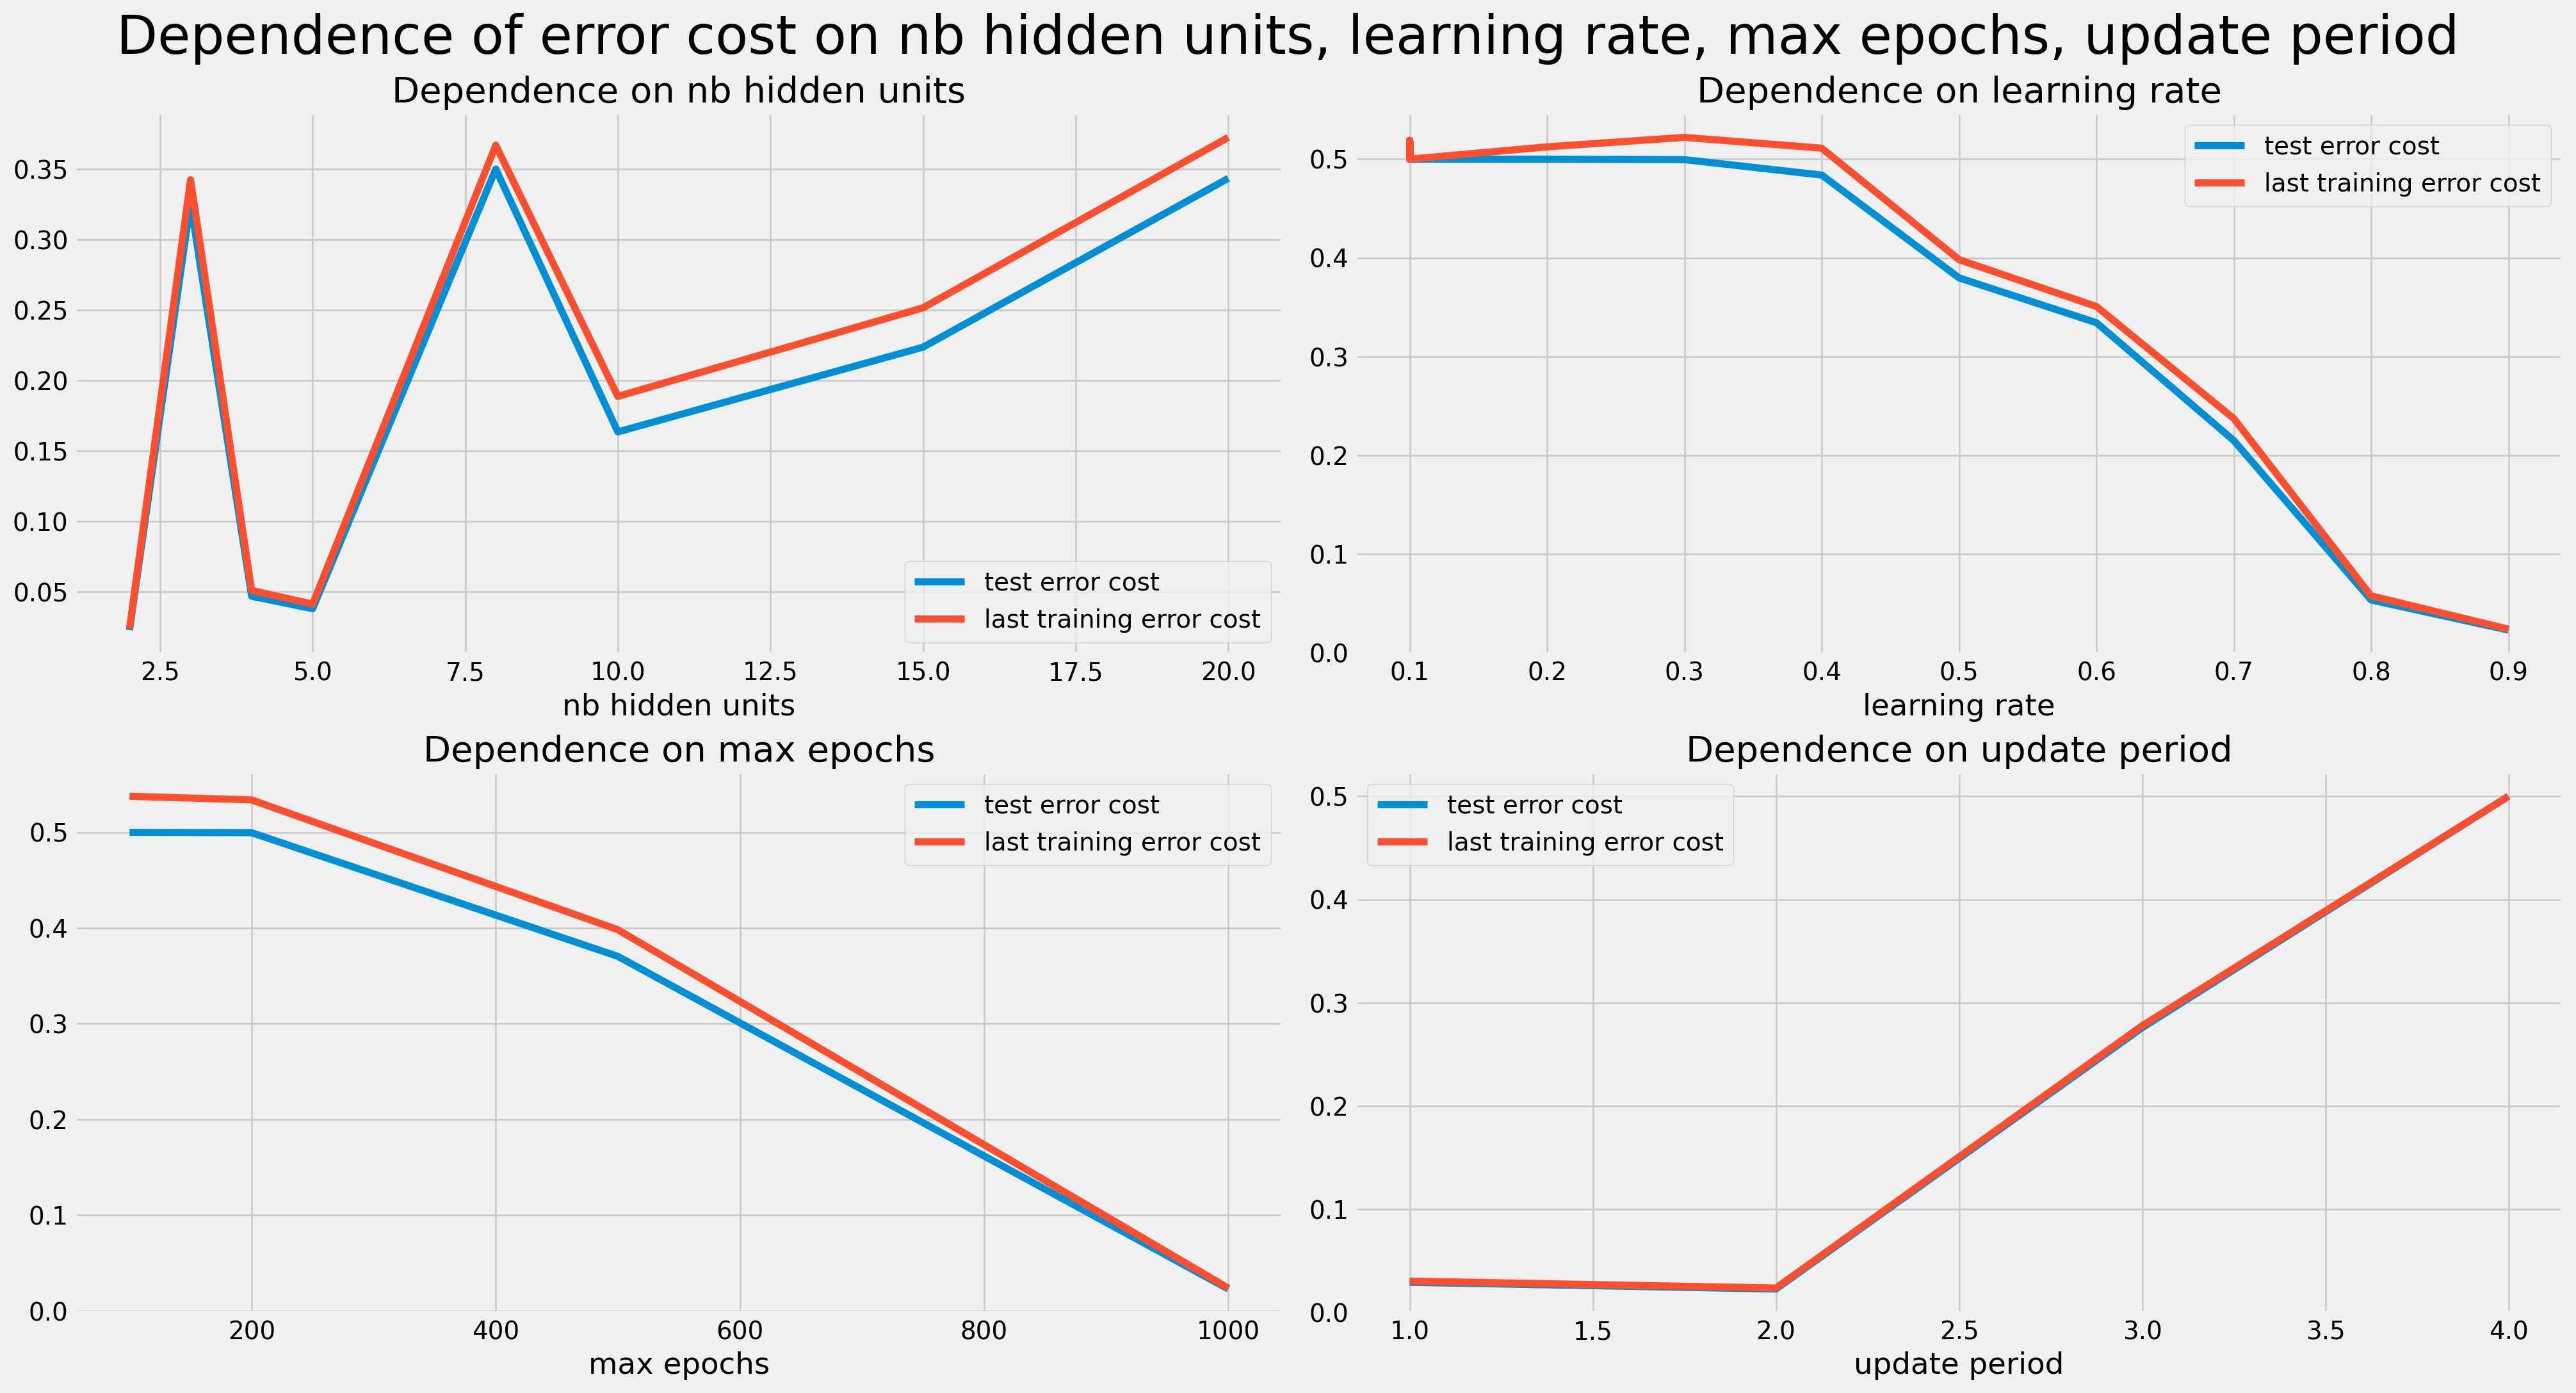

In [575]:
plot_for_column(xor_c, ['nb hidden units', 'learning rate', 'max epochs', 'update period'])

The most surprising thing in the graph depicting the dependence on `nb hidden units` are the peaks of error cost when we choose 3 or 8 hidden inputs.
The MLP seems to learn better with a learning rate close to 1 and a high number of training cycles. It would be interesting to see if with a higher number of epochs or a higher learning rate we could have a better cost or when we will reach a limit, but the error costs obtained here are already quite sufficient to simulate the XOR function with our neural network. In any case, 2 hidden inputs are enough to obtain optimal results.

# Estimation of the sine of the combination of 4 components

For this problem, I have chosen the following parameter variations:

- `nb hidden units: [4, 8, 10, 15, 20, 25, 40]`
- `learning rate: [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]`
- `max epochs: [100, 200, 500, 1000]`
- `update period: [1, 2, 4, 8, 12]`

The activation function for the hidden layer is logistic and the activation function for the output layer is linear since the sine function gives values between -1 and 1.

Inputs and outputs are generated randomly by a python script (`sin_generator.py`). 500 examples have been generated: 400 are used for training the network and the other 100 are used to test the efficiency of the network.

Sorting the results by the lowest error costs gives a very low cost around $10^{-5}$ for the test data:

In [576]:
sin = pd.read_csv('sin.data.csv', header=0)
columns = ['nb hidden units', 'learning rate', 'max epochs', 'update period', 'last training error cost', 'test error cost']
sin_c = sin[columns].dropna()
sin_c = sin_c[~sin_c['test error cost'].isin(('nan', '-nan(ind)'))]
sin_c['test error cost'] = sin_c['test error cost'].astype('float')
sin_c['last training error cost'] = sin_c['last training error cost'].astype('float')

In [577]:
sin_c.sort_values(by='test error cost').head(5)

,nb hidden units,learning rate,max epochs,update period,last training error cost,test error cost
1120,8,0.3,1000,1,0.000182,0.000038
1160,8,0.5,1000,1,0.000238,0.000049
920,4,0.2,1000,1,0.000192,0.000070
1140,8,0.4,1000,1,0.000414,0.000071
1155,8,0.4,500,1,0.000543,0.000072


On 400 training examples, we have an average error cost of $4.55^{-7}$ for the training and an average error cost of $3.8^{-7}$ for the tests using the best parameterization. So we have a pretty good approximation of the sine value on any combination of values.

The lowest error costs can be displayed according to each parameter: 

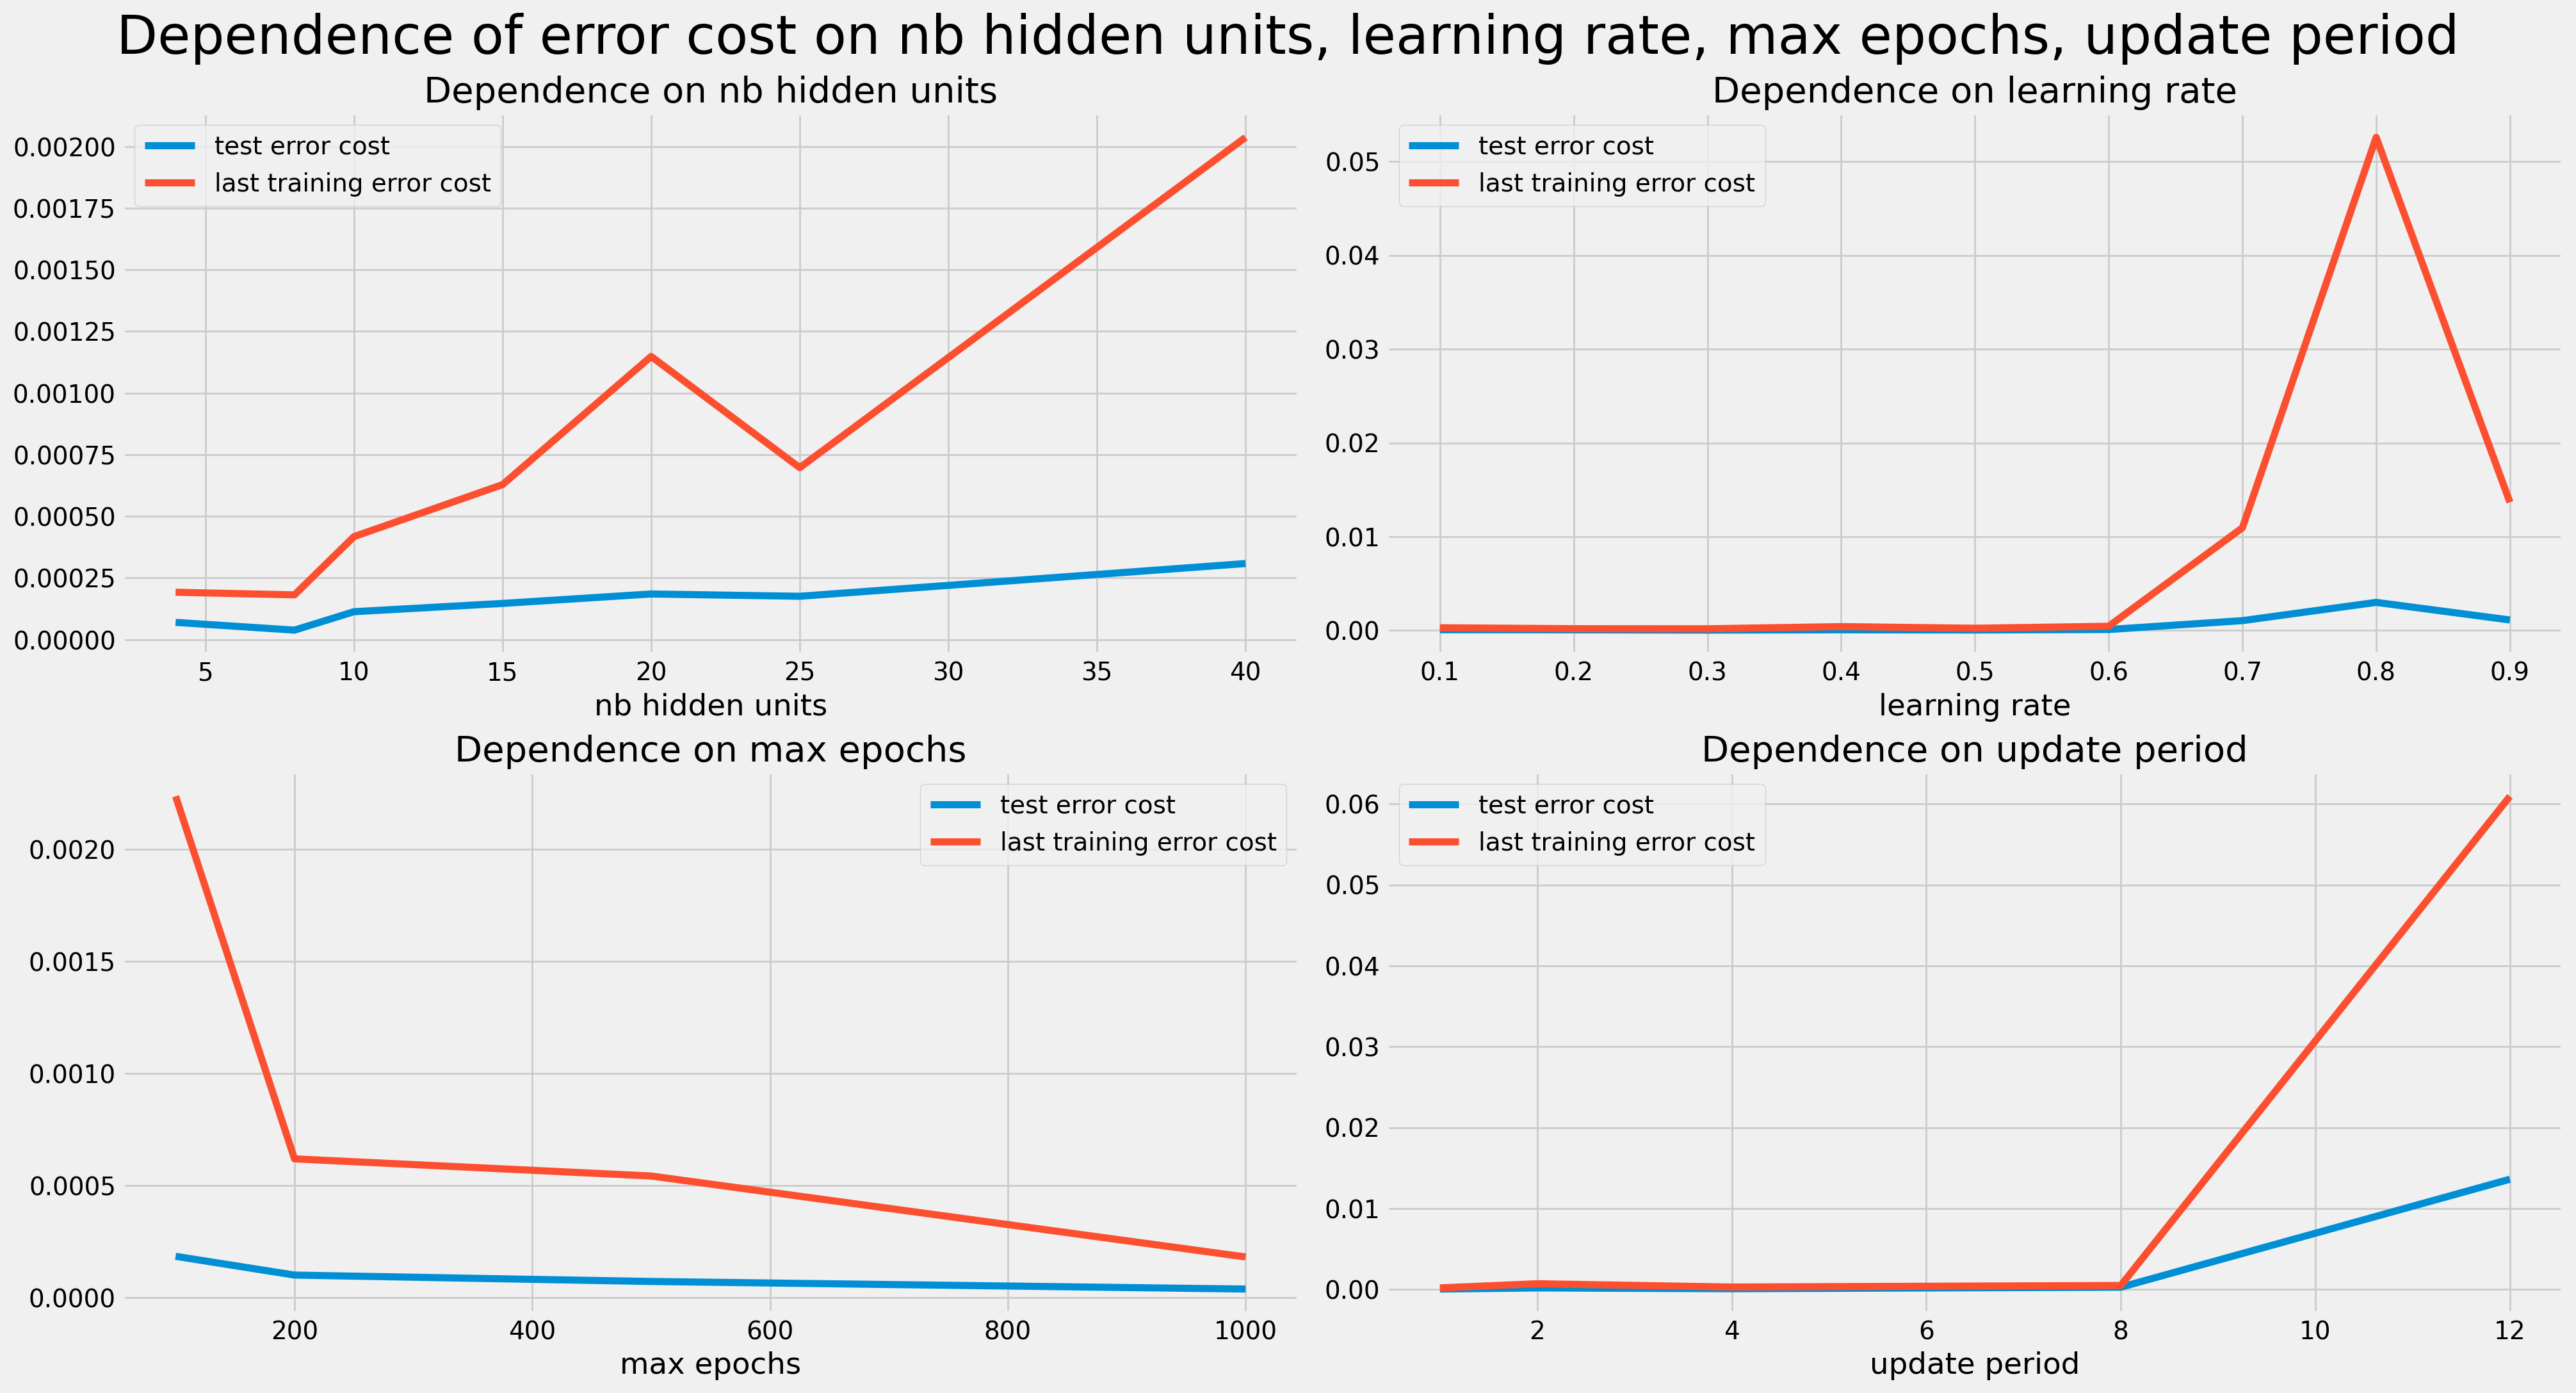

In [578]:
plot_for_column(sin_c, ['nb hidden units', 'learning rate', 'max epochs', 'update period'])

It seems that the optimal number of hidden units is between 5 and 10, but the difference with a higher number of hidden units is small ($<10^{-3}$). A high learning rate, in our case higher than 0.6, leads to an explosion of the error cost. The same is true for the update period, where we see a significant increase in the error cost after a period of 8.

# Classification of letters from images

For this problem, I have chosen the following parameters:

- `nb hidden units: [10, 20, 40, 75, 100]`
- `learning rate: [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]`
- `max epochs: [100, 200, 500, 1000]`
- `update period: [2, 4, 8, 16, 32]`

The activation function for the hidden layer is logistic and the activation function for the output layer is also logistic since we are facing a classification problem.

For the dataset, I used the dataset of the UCI Machine Learning repository which includes 20000 examples.
To make this dataset interpretable by my program, I introduced a pre-processing phase with a Python script which will transform the letters (a letter between A and Z) into a vector of size 26 of 0 and 1. The position of the unique 1 corresponds to the index of the given letter.
For instance the following line from the dataset: 

`T,2,8,3,5,1,8,13,0,6,6,10,8,0,8,0,8` 

is transformed into this line: 

`2,8,3,5,1,8,13,0,6,6,10,8,0,8,0,8 0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0` 

since `T` is the 20th letter of the alphabet.

Finally, to classify the test data, since a neural network only returns real outputs between 0 and 1, we choose the largest element in the output vector and assign it the value 1. The other elements take the value 0. The position of the single value 1 thus corresponds to the index of the predicted letter in the alphabetical order.
The misclassification rate is given by the number of misclassifications over the number of test examples.

By sorting the results by the lowest error rate, we reach in the best case an accuracy between 98 and 99%. For our 2000 examples, this corresponds to about 30 misclassified examples, which is really excellent.

In [579]:
letters = pd.read_csv('letters.data.csv', header=0)
columns = ['nb hidden units', 'learning rate', 'max epochs', 'update period', 'last training error cost', 'test error cost', 'test error rate']
letters_c = letters[columns]
letters_c.sort_values(by='test error rate').head(5)


,nb hidden units,learning rate,max epochs,update period,last training error cost,test error cost,test error rate
1,100,0.1,1000,2,91.6698,55.5080,0.01550
727,75,0.1,1000,8,98.7870,63.5224,0.01575
4,100,0.1,1000,8,77.6323,63.3414,0.01650
739,75,0.1,500,2,141.7240,65.9399,0.01675
18,100,0.1,500,4,135.6810,65.5109,0.01700


We can display the lowest error cost and error rate for each parameter: 

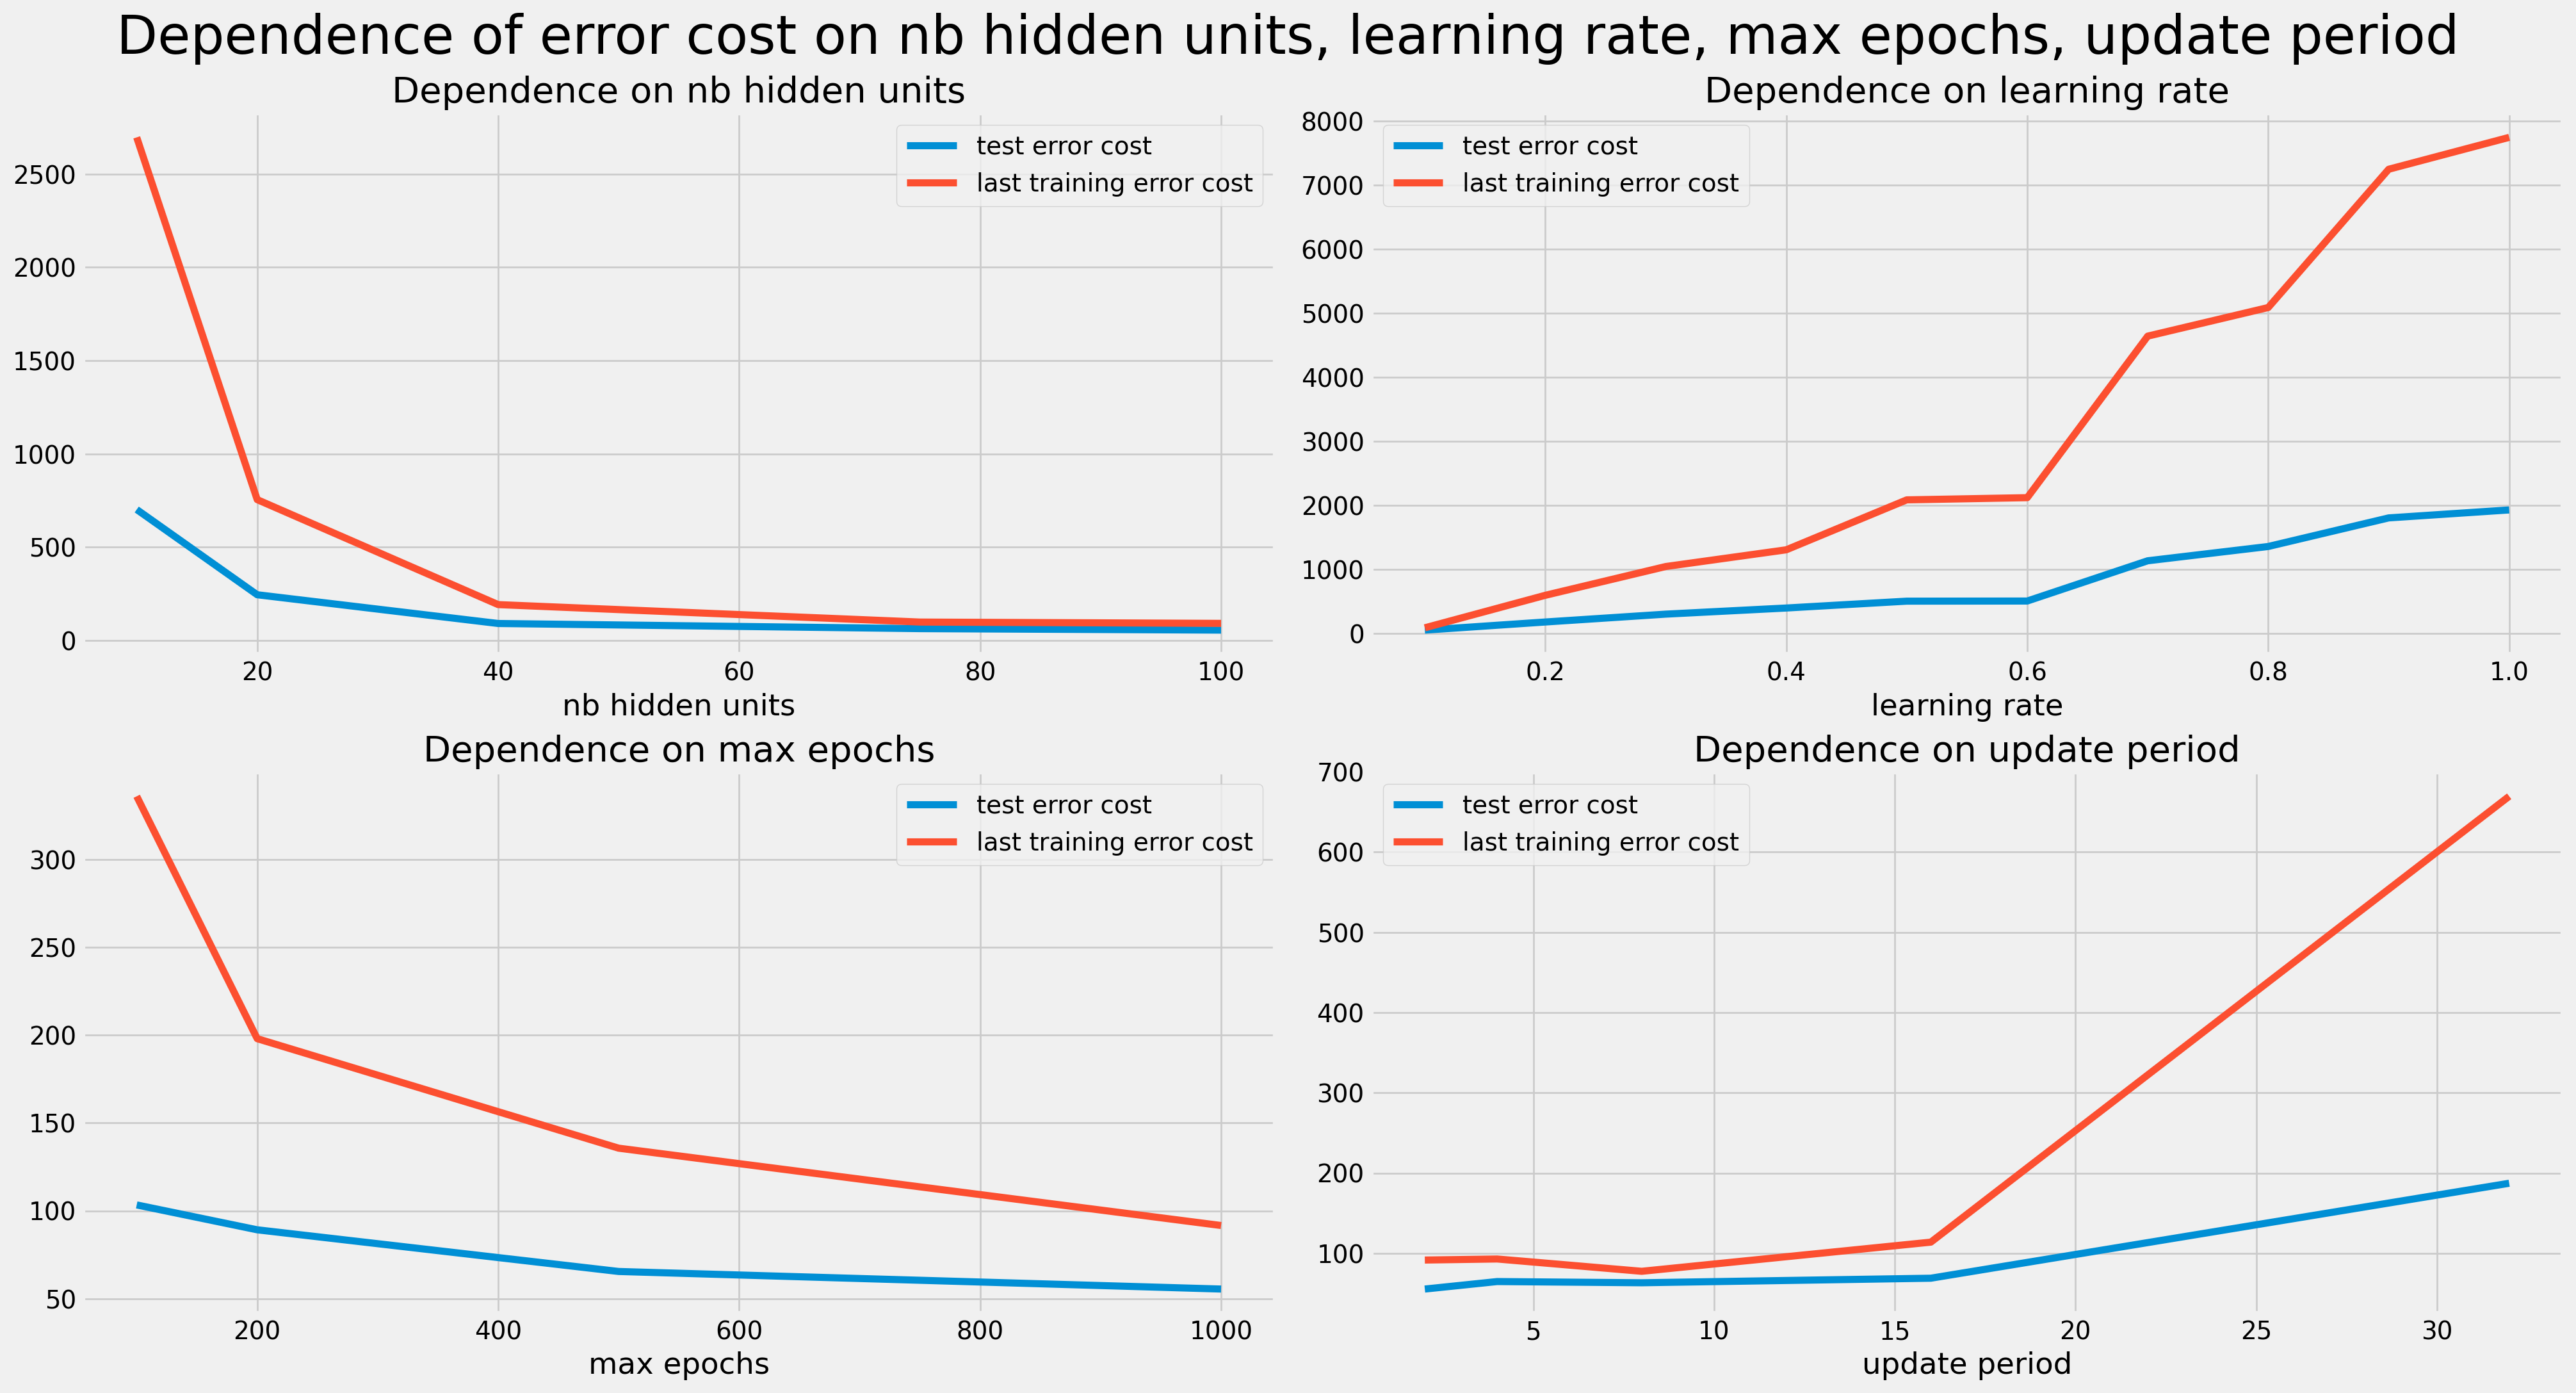

In [580]:
plot_for_column(letters_c, ['nb hidden units', 'learning rate', 'max epochs', 'update period'])

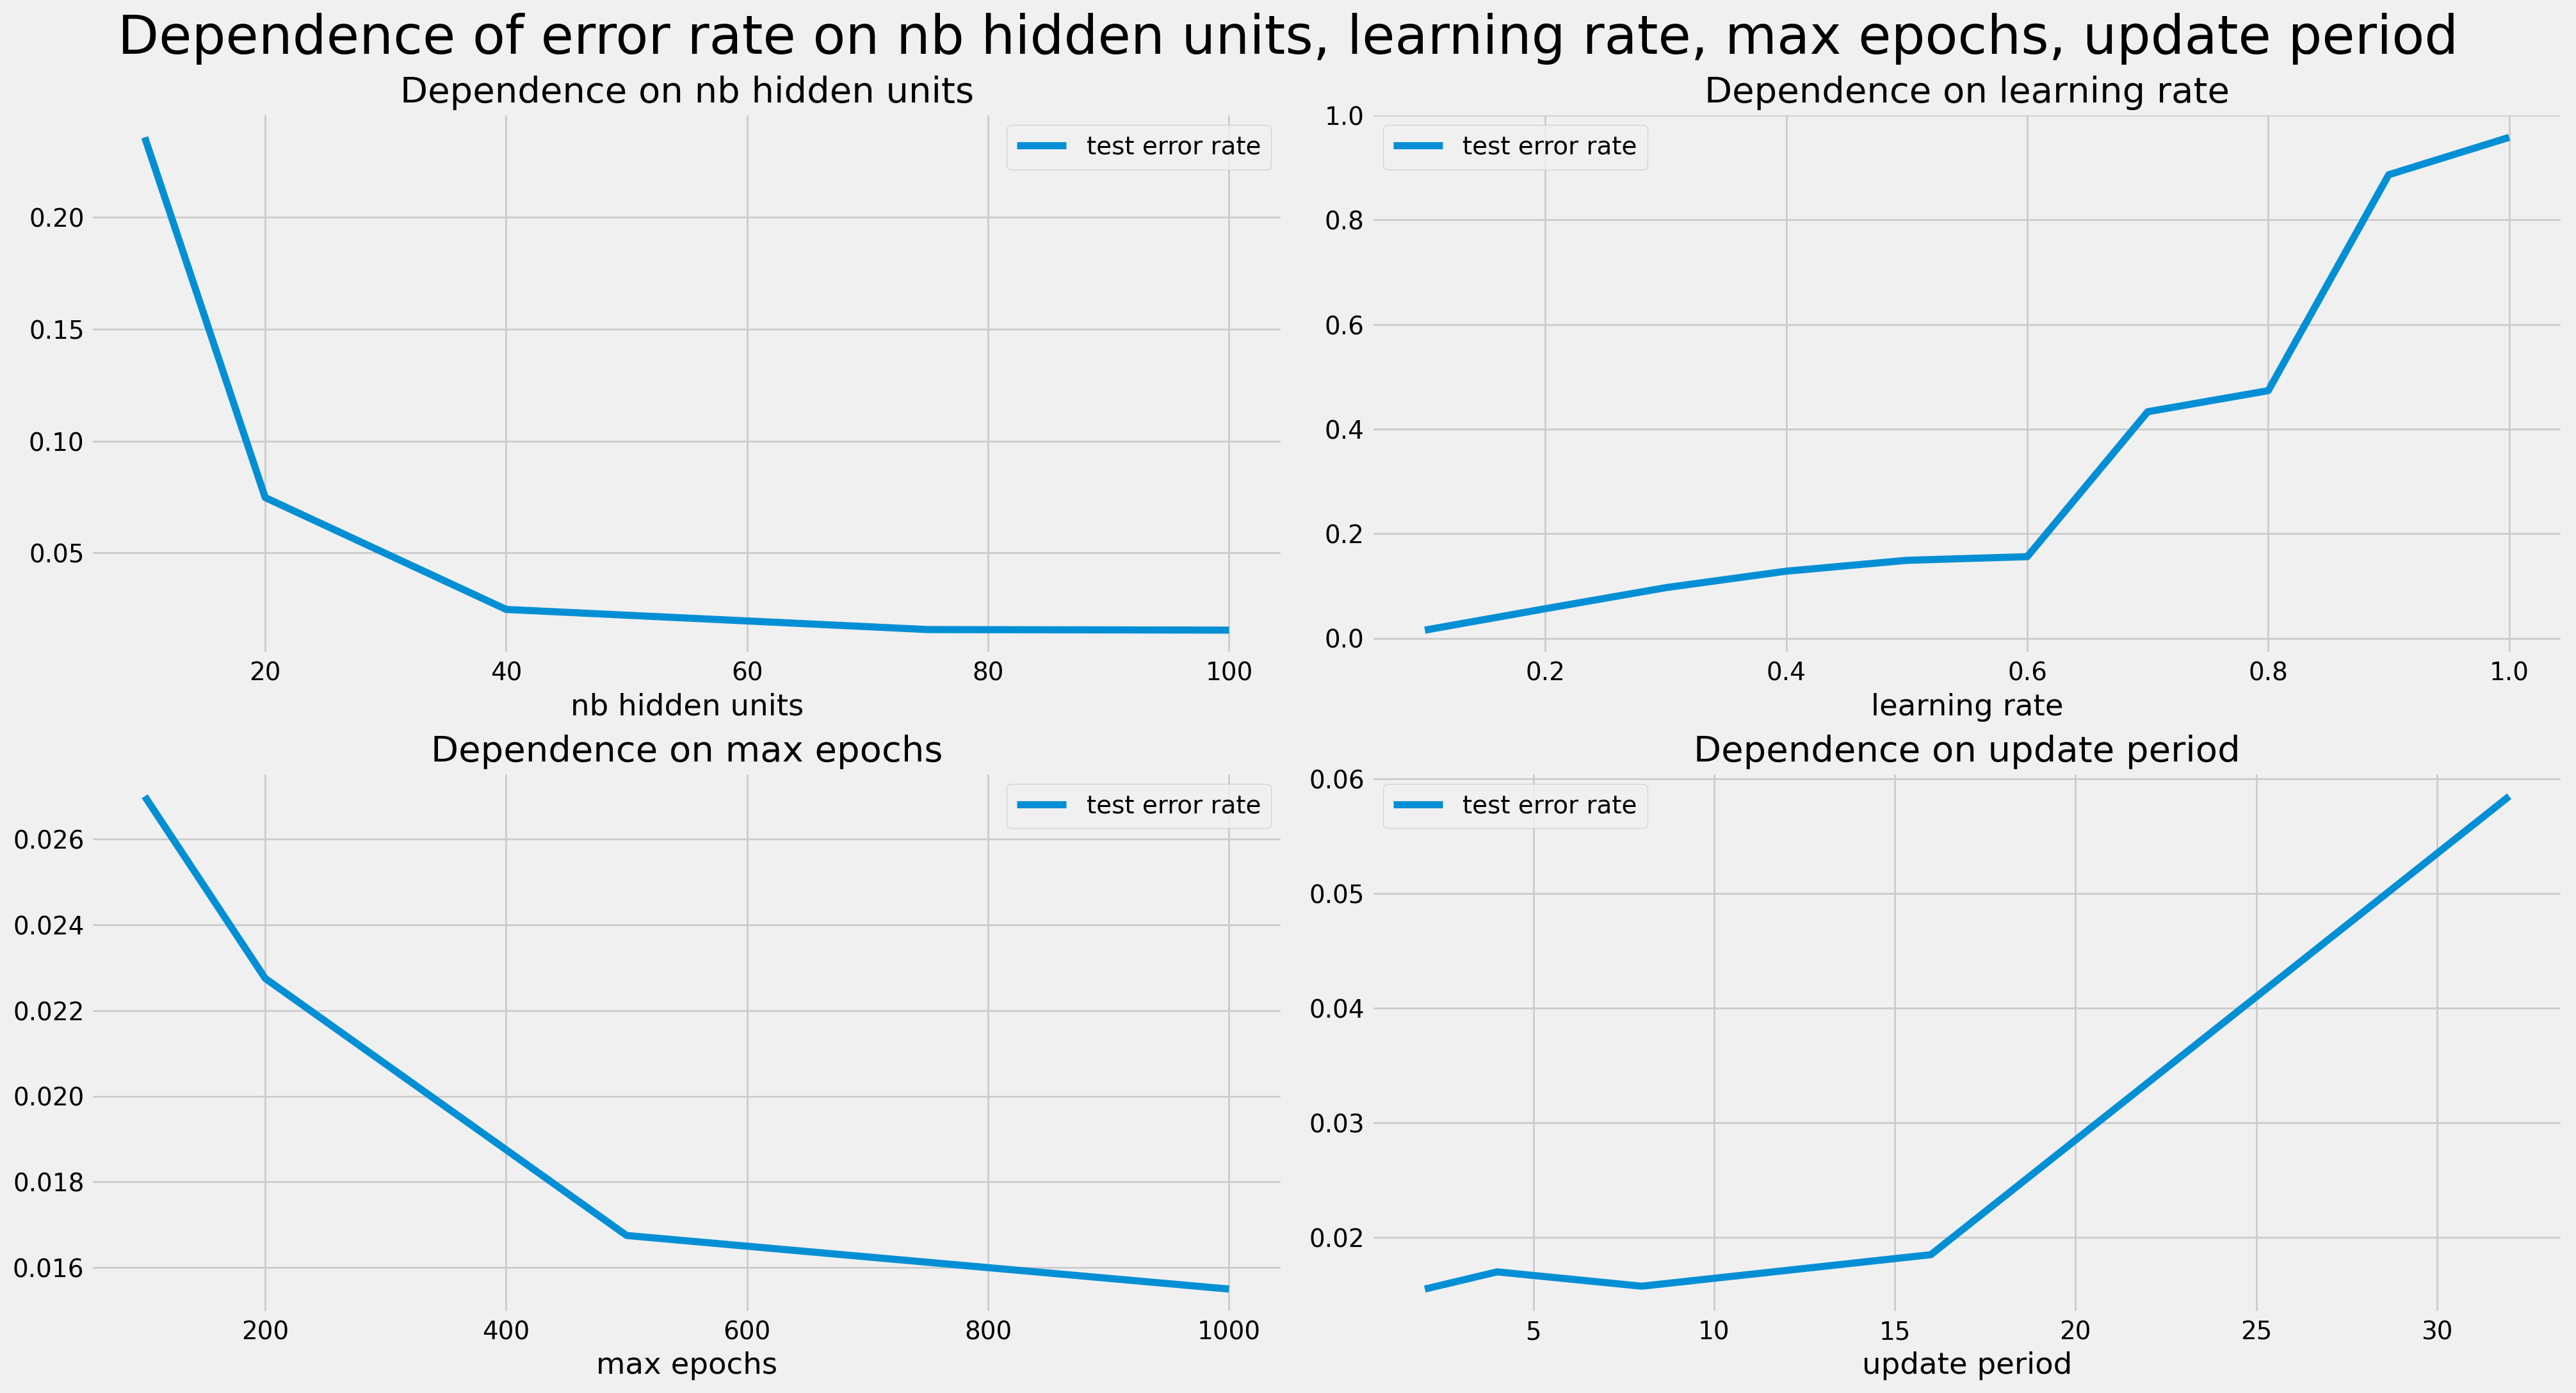

In [581]:
plot_error_rate_for_column(letters_c, ['nb hidden units', 'learning rate', 'max epochs', 'update period'])

We observe that even with a number of hidden inputs of 100, the curve always goes down and a low learning rate seems to be the best choice for better performance in general. Maybe increasing the number of hidden inputs could give even better results. However, we also notice that from 40 hidden units onwards the performance gain is rather low especially if we compare them to their associated training time:

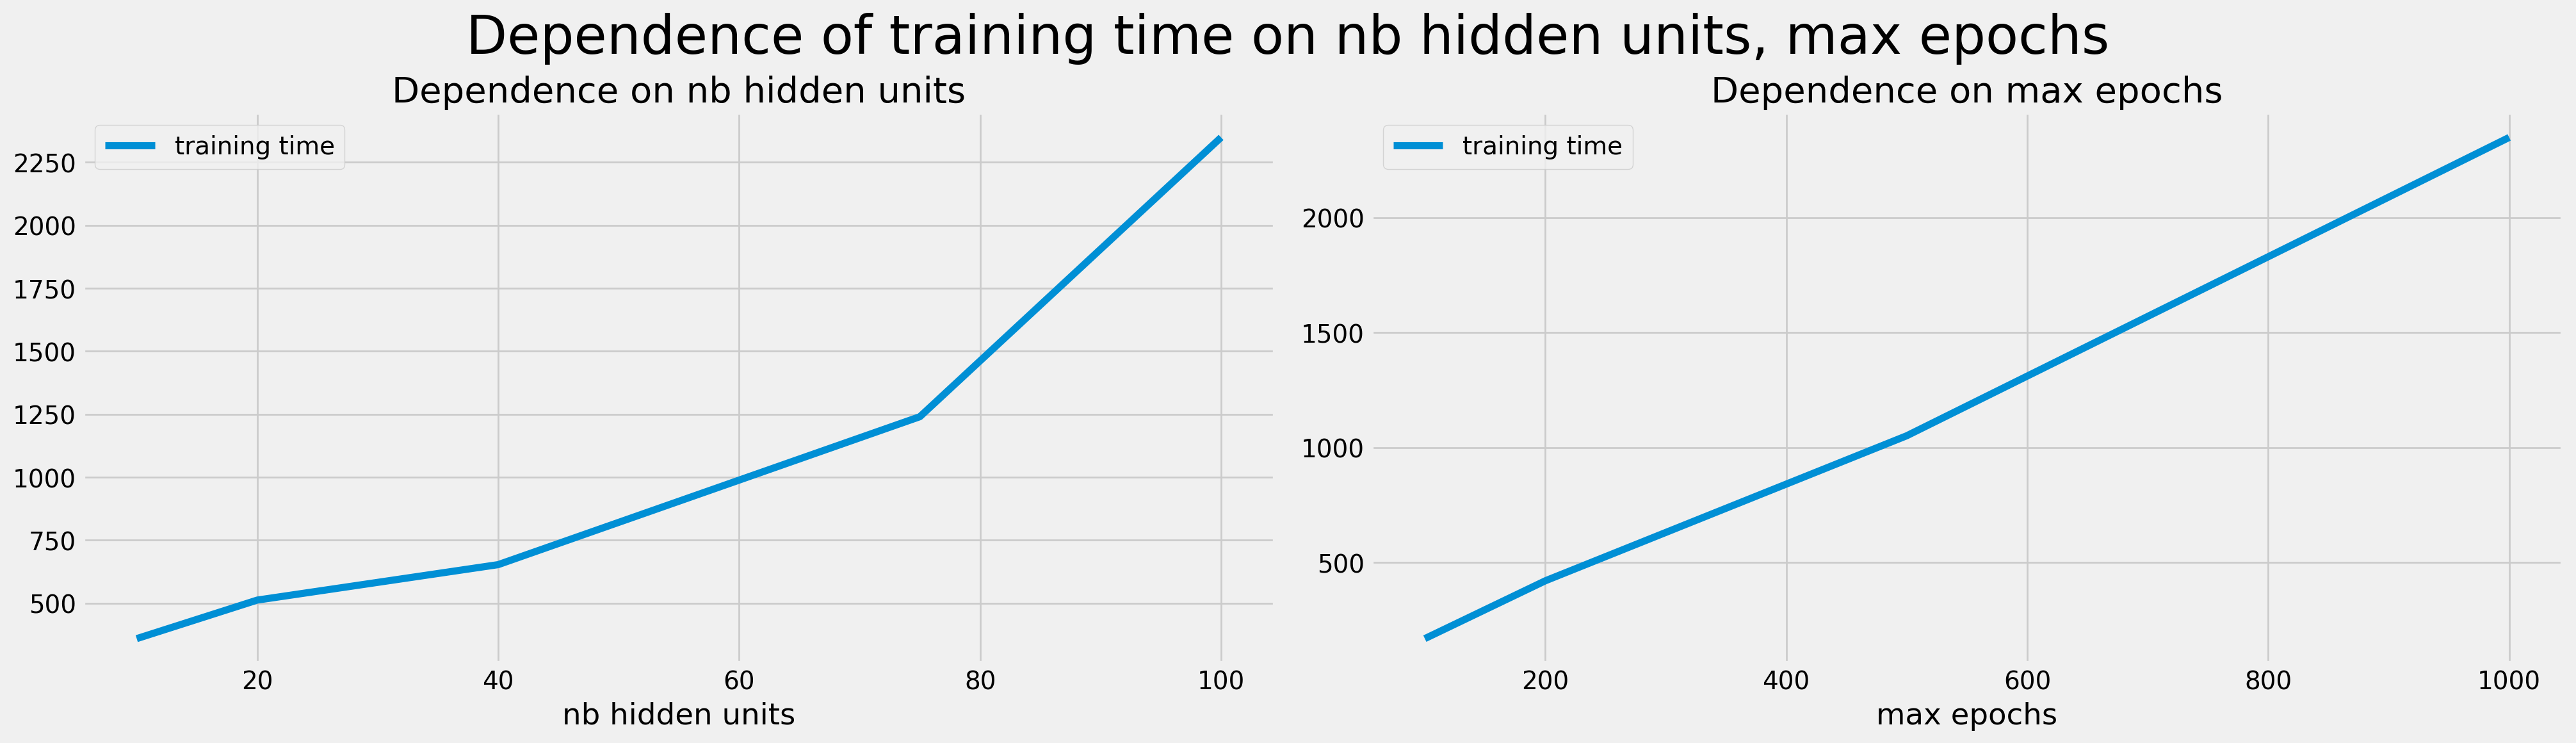

In [582]:
columns = ['nb hidden units', 'max epochs', 'training time', 'test error cost']
plot_training_time_for_column(letters[columns], ['nb hidden units', 'max epochs'])

Thus, to obtain a 1% performance gain, we would have to go from 40 to 100 hidden units and then quadruple the training time. We can also try to find equivalences in terms of performance but with a better training time by looking at the lowest error rate:

In [583]:
letters = pd.read_csv('letters.data.csv', header=0)
columns = ['nb hidden units', 'learning rate', 'max epochs', 'update period', 'test error rate', 'training time']
letters_c = letters[columns]
letters_c.sort_values(by='test error rate').head(20).sort_values(by='training time').head(10)

,nb hidden units,learning rate,max epochs,update period,test error rate,training time
8,100,0.1,100,4,0.02800,164.519
6,100,0.1,100,2,0.02700,169.161
562,40,0.1,500,8,0.02650,392.519
13,100,0.1,200,4,0.02275,420.613
11,100,0.1,200,2,0.02875,426.452
741,75,0.1,500,4,0.02700,604.179
739,75,0.1,500,2,0.01675,624.025
547,40,0.1,1000,8,0.02475,653.319
16,100,0.1,500,2,0.01775,1016.690
18,100,0.1,500,4,0.01700,1051.440


We can notice equivalent performances for less training time. For instance:

- 169 seconds with 100 hidden inputs, 0.1 learning rate, 100 epochs and update period of 2 for an accuracy of 97.3%
- 420 seconds with 100 hidden inputs, 0.1 learning rate, 200 epochs and update period of 4 for an accuracy of 97.8%
- 624 seconds with 75 hidden inputs, 0.1 learning rate, 500 epochs and update period of 2 for an accuracy of 98.4%

# Conclusion

As we have seen for the XOR problem or for letter recognition, the choice of the learning rate is very important. We can have a very good classifier with a certain learning rate as well as a mediocre classifier with another.

Moreover, more hidden units does not mean better performances. For example for XOR, some peaks are erratically present and in general the performance is worse if we increase the number of hidden units. More learning cycles may be needed in these cases to obtain similar results. These peaks may also be the cause of a bad initialization of the weights. It would then be interesting to run other tests but with predefined initialization to study their impact on the learning of a model.

Finally, we can find a configuration that performs as well as another one but with a reduced training time. In the case of very large data sets, adding training cycles can become very restrictive in terms of training time and it doesn't necessarily boost the network's performance. Opting for the adjustment of other parameters, such as the learning rate or the update period, before modifying the number of hidden inputs or the number of epochs can therefore be beneficial in the learning phase.

There are other areas of improvement to consider:

- gradually reducing the learning rate during the training step
- using different activation functions such as ReLU for hidden layer or hyperbolic tangent for output layer
- parallelizing learning step to significantly reduce learning time since matrix multiplication is easily parallelizable (and maybe directly use GPU)

